In [2]:
# !pip install --upgrade tensorflow==2.2.0rc4
# !pip install --upgrade tfp-nightly

In [3]:
import numpy as np
import tensorflow_probability as tfp
import tensorflow.compat.v2 as tf
import matplotlib.pyplot as plt
import time

tf.config.optimizer.set_jit(True)

def run_DGP(periods,dimensions):

    ##Data Generating Process######
    np.random.seed(1337)# this is the only part of the whole code which is stochastic

    n_dim = dimensions #INPUT # number of dimensions #

    t=np.array(periods) #INPUT #500  


    #try out different scales
    Q=np.array(0.001) #0.001
    R=np.array(0.01) #0.01
    Q_test = 0.001  
    R_test = 0.01


    #generate white noise series
    e1 = np.random.normal(0,1,[t, n_dim])
    #e1 = e1*Q
    e1 = e1*Q

    e2 = np.random.normal(0,1,[t, n_dim])
    e2 = e2*R

    e3 = np.random.normal(0,1,[t, n_dim])
    e3 = e3*Q_test

    #generate containers
    Beta = np.zeros(shape=[t, n_dim]) 
    Y= np.zeros(shape=[t, n_dim])


    #generate  X as N-(3,1) process
    X = np.random.normal(3,1,size=[t, n_dim])

    #generate state variable beta as random walk process, and Y as a function of this.

    for i in np.arange(0,n_dim):
        for j in np.arange(1,t).reshape(-1):
            Beta[j][i] = Beta[j-1][i] + e2[j][i]
            Y[j][i] = X[j][i]*Beta[j][i] + e1[j][i] +e3[j][i]  #+e4[j][n_dim-1]
    X_raw = X  
    Y_raw = Y

    return(X_raw, Y_raw, Beta)


In [4]:
class TVP_variational_optimization:
    
    def __init__(self, n_dim, K , window, Q_0, beta_b, t, Y, time):
         # n_dim x n_dim 
        sigma_bar = np.identity(n_dim)*0.05
        
        self.sigma_inv = tf.convert_to_tensor(tf.linalg.inv(sigma_bar), dtype=tf.float64)
        self.Q_inv = tf.convert_to_tensor(tf.linalg.inv(Q_0), dtype=tf.float64)
        # background beta
        self.beta_b = tf.convert_to_tensor(beta_b, dtype=tf.float64)

        self.beta = tf.Variable(np.zeros((n_dim*K, 1)), dtype=tf.float64)
        self.n_dim = n_dim
        self.time = time
        self.Y = tf.convert_to_tensor(Y, dtype=tf.float64)
        self.K = K
        self.t = t
        self.window = window
        self.optimizer = tf.keras.optimizers.Adam(lr=0.001, epsilon=1e-07)
        
    def cost(self,x):
#     def cost(self):
        self.beta = tf.reshape(x, (x.shape[0],1))
        beta_b_beta = (self.beta_b - self.beta)
        beta_b_beta_transpose = tf.transpose(beta_b_beta)
        
        beta_b_beta_Q_0 = tf.matmul(beta_b_beta_transpose, self.Q_inv)
        J_b = tf.matmul(beta_b_beta_Q_0,beta_b_beta)
        J_0 = 0
        effective_window = self.window
        if(self.t + effective_window > self.time):
            effective_window = self.time - self.t

        if self.window == 1:
            Y_new = tf.reshape(self.Y[self.t],[self.n_dim,1])
            residual = Y_new - tf.matmul(self.X[0], self.beta)
            residual_t = tf.transpose(residual)
            residula_sigma = tf.matmul(residual_t, self.sigma_inv)
            J_0 = tf.matmul(residula_sigma,residual)
        else:
            effective_window = self.window
            if self.t + effective_window > self.time:
                effective_window = self.time - self.t
            t = self.t
            tau = self.t + effective_window

            x_beta = tf.einsum("abc,cd->abd", self.X, self.beta)
            Y_new = tf.reshape(self.Y[t:tau], [effective_window, self.n_dim, 1])
            residual = Y_new - x_beta
            residual_t = tf.transpose(residual, perm=[0,2,1])
            residual_sigma = tf.einsum("abc,cd->abd", residual_t, self.sigma_inv)
            total_residual_cost = tf.einsum("abc,acd->abd", residual_sigma, residual)
            J_0 = tf.reduce_sum(total_residual_cost, 0)
#         return J_b + J_0
        return tf.reshape(J_b + J_0, ())


    def loss_and_gradient(self,x):
        return tfp.math.value_and_gradient(self.cost,x)

    
    def optimize_w(self):  
#         losses = tfp.math.minimize(self.cost, num_steps=10, optimizer=self.optimizer)
#         return self.beta
        start = tf.reshape(self.beta_b, (self.beta_b.shape[0]))
        output = tfp.optimizer.lbfgs_minimize(lambda x : tfp.math.value_and_gradient(self.cost, x), initial_position=start, tolerance=1e-8)
        return output.position
        


In [5]:
def get_transformed_beta(time,n_dim, beta):
    transformed = np.zeros((time,n_dim), dtype  = np.float)
    for t in range(0,time):
        a = int(beta[t,:,0].shape[0]/n_dim)
        b2 = np.reshape(beta[t,:,0],(n_dim,a))
        transformed[t] = np.diag(b2)
    return transformed
  

def plot(time_dim,n_dim,beta,Beta,y_hat,Y):
    transformed_beta = get_transformed_beta(time_dim,n_dim, beta)
    fig2, ax = plt.subplots(1,2,figsize=(17,5))
    ax[0].set_title(r'Beta') 
    ax[0].plot(transformed_beta[:100,0],linestyle = '--')
    ax[0].plot(Beta[:100,0])
    ax[1].set_title(r'Real and Forecasted values $Y$') 
    ax[1].plot(y_hat[:100,0],linestyle = '--')
    ax[1].plot(Y[:100,0])
    plt.pause(0.005)
    plt.tight_layout()
    plt.show()

def mse_error(y_hat,y):
    return ((Y.T-Y_hat.T)**2).mean(axis=1).mean()

(200, 3)
At time : 0
At time : 100
For n_dim : 2 and time :  200 and window : 1
runtime : 2.9842782020568848
Mse error :1.485507325831267e-08
Loop avg time :  0.014710170030593873


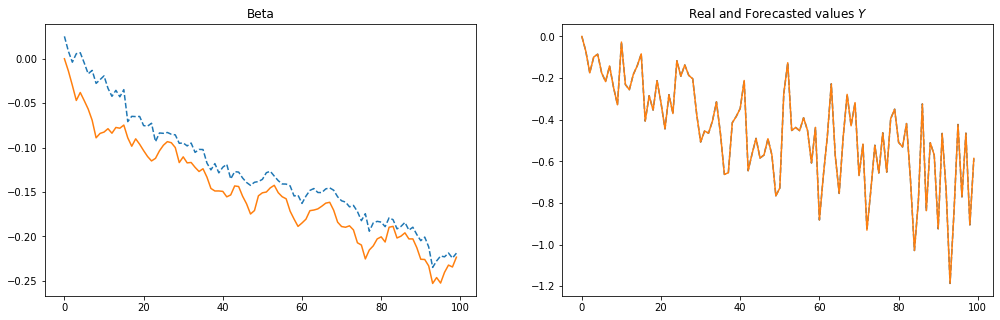

<Figure size 432x288 with 0 Axes>

In [10]:
time_dim = 200
n_dim = 2
window =1
lag_length = 0
K = n_dim + 1
Q_0 = np.eye(n_dim*K)*1.01
beta_b = np.eye(n_dim*K,1)*0.06 
qK = n_dim*K
beta = np.zeros([time_dim,qK,1])
I = np.identity(n_dim)
X,Y,Beta = run_DGP(periods=time_dim,dimensions=n_dim)
X = np.concatenate((X, np.ones(shape=[time_dim, 1])), axis=1)


optimizer = TVP_variational_optimization(n_dim, K, window, Q_0, beta_b,0, Y, time_dim)
Y_hat = np.zeros(shape=[time_dim, n_dim])
x = np.zeros((window, n_dim, qK))
print(X.shape)
start = time.time()
avg = 0
for t in range(0,time_dim,window) :
    if(t%100 == 0):
        print("At time : " + str(t))

    for tau in range(0, window):
        if t + tau >= time_dim:
            break
        x[tau] = np.kron(I, X[t + tau, :].T)

    optimizer.X = tf.convert_to_tensor(x, dtype = tf.float64)
   
    optimizer.t = t
    
    start1 = time.time()
    optim = optimizer.optimize_w().numpy()
    start2 = time.time()
    avg += start2 - start1

    beta[t] = optim.reshape(optim.shape[0], 1)

    #Copying over beta{t} ot beta{t+1}..beta{t + tau} as Forecaset matrix F = Identity.
    for tau in range(0,window):
        if(t+tau >= time_dim):
            break
        beta[t+tau] = beta[t]
        Y_hat[t+tau] = np.reshape((x[tau] @ beta[t]),(n_dim))
    # background beta update
    beta_b = beta[t]
    optimizer.beta_b = tf.convert_to_tensor(beta_b, dtype=tf.float64)
end = time.time()

print("For n_dim : " + str(n_dim) + " and time : ", str(time_dim) + " and window : " + str(window) )
print('runtime :',end - start)
print("Mse error :" + str(mse_error(Y_hat,Y)))
ttt = int(time_dim/window)
print("Loop avg time : ", str(avg/ttt))
plot(time_dim,n_dim,beta,Beta,Y_hat,Y)




# 101 Adam
# For n_dim : 30 and time :  1000 and window : 1
# runtime : 148.6510353088379
# Mse error :0.008406496615810473

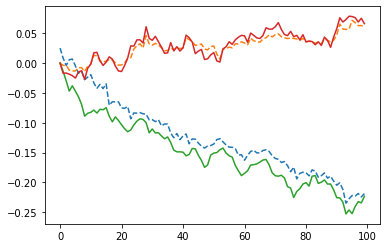

In [11]:
transformed_beta = get_transformed_beta(time_dim,n_dim, beta)
# plt.set_title(r'Beta') 
plt.plot(transformed_beta[:100],linestyle = '--')
plt.plot(Beta[:100])